# Battle of the Neighborhoods
## Coursera Capstone

## Introduction / Business Problem

A client wishes to open up a business of his/her choice in the city of Toronto. The client however does not know what optimal location to place their business in. Our task is to select/recommend a suitable location for them.

## Data

For this assignment, we will look at a location using data such as postal code and clusters from our previous modules. We will combine this data with input from the client (i.e. max radius from nearest business of the same type, type of business) and Foursquare API calls to see similar business in the same viscinity. Combining this data we will use K-Nearest Neighbor from the sci-kit library to show the clusters of businesses and show a representation of this on a Folium map. We will then recommend (2) possible locations for the client:

1. A location that is optimized inside the cluster of similar business types since consumers may look to goto that cluster from previous experience to find that particular business.
2. A location where there are none of that type of business in that cluster which will introduce no competition for our client since it will only be the client serving their particular kind of customers.

## Methodology

We will generate a map of NYC's 5 boroughs for this Capstone. I originally was going to use Toronto as the basis for this analysis but upon experimenting with Foursquare API, I am unable to return search queries for that area. Potentiall this can be due to COVID-19 having businesses closed for the time being and resulting in no open businesses of the query search. I have had more success using New York City to obtain query searches, therefore I will proceed with NYC. 

*For Module 3 reference please see*: [Week_3 Notebook](https://github.com/jye0325/Coursera_Capstone/blob/master/Week_3.ipynb)

### List of NYC Neighborhoods are downloaded

In [ ]:
!wget -O index.html https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm

### Neighborhoods are then converted to a DataFrame using BeautifulSoup and Pandas

In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

fp = open('index.html', encoding="utf-8")
soup = BeautifulSoup(fp, 'html5lib')
table = soup.table.prettify()

df = pd.read_html(table, na_values=[])
df = df[0]

### Modify the table to have Zip Codes listing Neighborhoods

In [ ]:
# Rearrange columns
df = df[['ZIP Codes', 'Borough', 'Neighborhood']]
df_copy = pd.DataFrame()
for index, row in df.iterrows():
    splits = row[0].split(',')
    for split in splits:
        a_row = pd.Series([split.strip(), row[1], row[2]])
        a_row = pd.DataFrame([a_row])
        df_copy = pd.concat([a_row, df_copy])
df_copy.rename(columns={0:'ZIP Code', 1:'Borough', 2:'Neighborhood'}, inplace=True)
df_copy.reset_index(drop=True, inplace=True)

### Google Geocoding API used to obtain latitude and longitude of the Zip Codes.
**Note: API Key will not be disclosed in this `.ipynb` file or Github commit!**

In [ ]:
# Commented out to avoid accidentally making API Calls to Google API for quota purposes.
"""import requests
import time
import json

zip_codes = pd.DataFrame()

with open('google_cloud_credentials.json', 'r') as f:
    datastore = json.load(f)

for z in df_copy['ZIP Code']:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?'
    data = {
        "address":"{}".format(z),
        "key":datastore['key']
    }
    response = requests.get(url, params=data)

    data = json.loads(response.text)

    location = data['results'][0]['geometry']['location']

    a_row = pd.Series([z, float(location['lat']), float(location['lng'])])
    a_row = pd.DataFrame([a_row])
    zip_codes = pd.concat([a_row, zip_codes])"""

In [ ]:
# zip_codes.rename(columns={0:'ZIP Code', 1:'Latitude', 2:'Longitude'}, inplace=True)
# zip_codes.reset_index(drop=True, inplace=True)

### Save `zip_codes` DataFrame to Avoid Extra API Calls to Google

In [ ]:
## Commented out to avoid accidentally overriding existing .csv file with a blank DataFrame if Kernel is restarted.
# zip_codes.to_csv('zip_codes.csv')

### Load `zip_codes` into a DataFrame (when restarting kernel or notebook) and modify data types to be compatible

In [ ]:
zip_codes = pd.read_csv('zip_codes.csv', index_col=0)
zip_codes['ZIP Code'] = zip_codes['ZIP Code'].astype(int)
zip_codes['Latitude'] = zip_codes['Latitude'].astype(float)
zip_codes['Longitude'] = zip_codes['Longitude'].astype(float)

In [ ]:
zip_codes

### Modify `df_copy` data types to be compatible

In [ ]:
df_copy['ZIP Code'] = df_copy['ZIP Code'].astype(int)
df_copy['Borough'] = df_copy['Borough'].astype(str)
df_copy['Neighborhood'] = df_copy['Neighborhood'].astype(str)

### Merge the two DataFrames

In [ ]:
result = pd.merge(df_copy, zip_codes, how="left", on=['ZIP Code'])

result

### Folium Map of our current clusters

In [33]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster

address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City, NY are {}, {}.'.format(latitude, longitude))

# create map of Toronto using latitude and longitude values
map_nyc = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(result['Latitude'], result['Longitude'], result['Borough'], result['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)
        
map_nyc.save("map_nyc.html")
map_nyc

The geograpical coordinate of New York City, NY are 40.7127281, -74.0060152.


## NYC Map with Zip Codes Populated for Github Viewing

![NYC Map with Zip Codes](nyc_map_with_zip_codes.png)

## Create cluster based on neighborhoods

#### Create GeoJSON

In [49]:
nlist = df['Neighborhood']
neighborhood_list = []
for neighborhood_name in nlist:
    coordinates = []
    df_temp = result[result.Neighborhood == neighborhood_name]
    for index, row in df_temp.iterrows():
        coordinates.append([row['Longitude'],row['Latitude']])
    neighborhood_list.append({"type": "Feature", "properties": {"name": neighborhood_name}, "geometry": {"type": "Polygon", "coordinates": [coordinates]}})

neighborhood = {"type": "FeatureCollection", "features": neighborhood_list}

## Let us start with importing Foursquare API.
For this example we will perform Foursquare API Calls to query `coffee shop` within `50 meter` radius in for the ZIP codes in our DataFrame.
We will then populate the data into a DataFrame.

In [ ]:
import json, requests
url = 'https://api.foursquare.com/v2/venues/explore'

store_db = pd.DataFrame()

with open('foursquare_credentials.json', 'r') as f:
    datastore = json.load(f)

for z, lat, lng in zip(zip_codes['ZIP Code'], zip_codes['Latitude'], zip_codes['Longitude']):
    params = dict(
    client_id=datastore['client_id'],
    client_secret=datastore['client_secret'],
    v='20180323',
    near='{}'.format(z),
    #ll='{},{}'.format(lat, lng),
    #ll='40.712,-74.006',
    radius=1609.34, # Equivalent to 1 mile
    query='coffee shop',
    limit=50
    )
    resp = requests.get(url=url, params=params)
    data = json.loads(resp.text)

    print("For ZIP Code: {}, we found:".format(z))

    for d in data['response']['groups'][0]['items']:
        print(d['venue']['name'])
        venue_name = d['venue']['name']
        venue_id = d['venue']['id']
        summary = str(d['reasons']['items'][0]['summary'])
        if summary.find('This spot is popular') > 0:
            rating = 1 
        else: 
            rating = 0
        lat = d['venue']['location']['lat']
        lng = d['venue']['location']['lng']
        a_row = pd.Series([int(z), str(venue_name), str(venue_id), int(rating), float(lat), float(lng)])
        a_row = pd.DataFrame([a_row])
        store_db = pd.concat([a_row, store_db])

### Cleanup the DataFrame

In [ ]:
store_db.rename(columns={0:'ZIP Code', 1:'Venue Name', 2:'Venue ID', 3:'Rating', 4:'Latitude', 5:'Longitude'}, inplace=True)
store_db.reset_index(drop=True, inplace=True)

In [ ]:
store_db.shape

### Save query to `.csv` file

In [ ]:
store_db.to_csv('coffee_shops_within_1mi.csv')

In [ ]:
store_db = pd.read_csv('coffee_shops_within_1mi.csv', index_col=0)
store_db['Venue Name'] = store_db['Venue Name'].astype(str)
store_db['Venue ID'] = store_db['Venue ID'].astype(str)
store_db['Rating'] = store_db['Rating'].astype(int)
store_db['Latitude'] = store_db['Latitude'].astype(float)
store_db['Longitude'] = store_db['Longitude'].astype(float)

With the populated data in the DataFrame, we will use this to plot the locations on our Folium Map.

In [ ]:
from folium import plugins
from 

# let's start again with a clean copy of the map of San Francisco
# store_map = folium.Map(location = [40.7127281, -74.0060152], zoom_start = 5)

# instantiate a mark cluster object for the incidents in the dataframe
stores = plugins.MarkerCluster().add_to(store_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(store_db['Latitude'], store_db['Longitude'], store_db['Venue Name']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(stores)

# display map
# sanfran_map.save('map_nyc_cluster.html')
#map_nyc.save('map_nyc_coffee_shops_5_mi.html')
map_nyc

In [ ]:
map_nyc.save('test.html')

Option 1: We can use Chloropleth Heatmaps to create hotspot neighborhoods for coffee shop counts

In [32]:
neighborhood_coffee_shop = pd.merge(store_db, result[['ZIP Code', 'Neighborhood']], how="left", on=['ZIP Code'])
count = pd.value_counts(neighborhood_coffee_shop['Neighborhood'])
coffee_shop_count = pd.DataFrame({'Neighborhood':count.index, 'Total':count.values})
coffee_shop_count

,Neighborhood,Total
0,Southeast Queens,385
1,North Queens,316
2,Upper East Side,300
3,Chelsea and Clinton,300
4,Lower Manhattan,300
5,Northwest Queens,298
6,Jamaica,251
7,Central Harlem,250
8,Northwest Brooklyn,250
9,West Queens,233


In [50]:
# Create a plain world map
m = folium.Map(zoom_start=12, location=[40.7127281, -74.0060152])

# Generate Choropleth Map
folium.Choropleth(
    geo_data=neighborhood,
    name='choropleth',
    data=coffee_shop_count,
    columns=['Neighborhood', 'Total'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Coffee Shop Popularity'
).add_to(m)

# Display Map
m

Option 2: We can create clusters to 

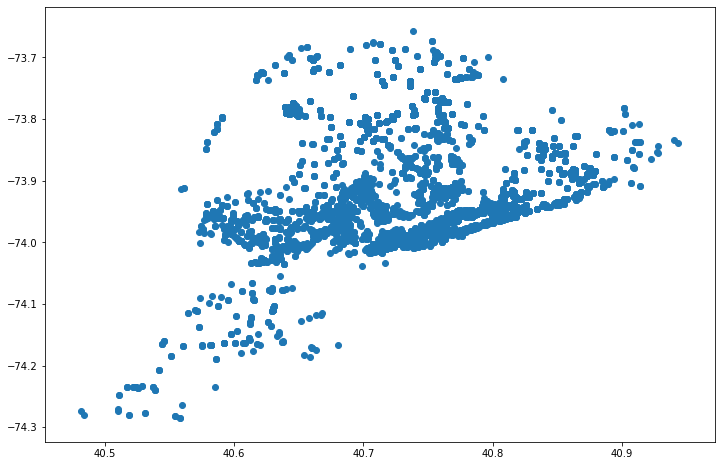

In [134]:
import matplotlib as mpl
import matplotlib.pyplot as plt

pp = store_db[['Latitude', 'Longitude']]
plt.figure(figsize=(12, 8))
plt.scatter(x=pp['Latitude'], y=pp['Longitude'])

In [121]:
from sklearn.cluster import KMeans
import numpy as np

pp = pp[['Latitude','Longitude']].to_numpy()
k_means = KMeans(init = "k-means++", n_clusters = 10, n_init = 12)
k_means.fit(pp)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [122]:
k_means_labels = k_means.labels_
k_means_labels

array([7, 7, 7, ..., 2, 2, 4])

In [123]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[ 40.730407  , -73.81591835],
       [ 40.73281819, -73.99286169],
       [ 40.86051492, -73.87479775],
       [ 40.62148987, -73.98987448],
       [ 40.80096839, -73.94899771],
       [ 40.75193623, -73.73568423],
       [ 40.68351083, -73.95125182],
       [ 40.58916628, -74.16129455],
       [ 40.64556176, -73.76889262],
       [ 40.75213666, -73.90488601]])

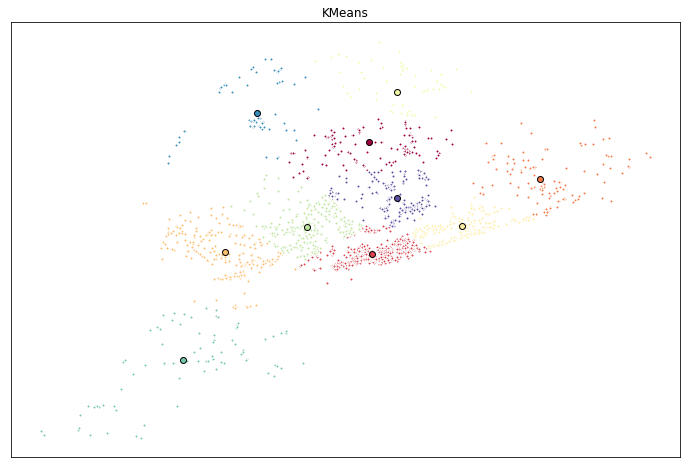

In [132]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(12, 8))

# Colors uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# For loop that plots the data points and centroids.
# k will range from 0-3, which will match the possible clusters that each
# data point is in.
for k, col in zip(range(len([[4,4], [-2, -1], [2, -3], [1, 1], [4,5], [5,4], [7,7], [8,8], [9,9], [10,0], [11,10]])), colors):

    # Create a list of all data points, where the data poitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # Plots the datapoints with color col.
    ax.plot(pp[my_members, 0], pp[my_members, 1], 'w', markerfacecolor=col, marker='.')
    
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)

# Title of the plot
ax.set_title('KMeans')

# Remove x-axis ticks
ax.set_xticks(())

# Remove y-axis ticks
ax.set_yticks(())

# Show the plot
plt.show()


In [147]:
import matplotlib.colors as colors

pp = store_db[['Latitude', 'Longitude']]
# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(pp)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:]

kmeans.labels_.shape

pp.insert(0, 'Cluster Labels', kmeans.labels_)

# create map
map_clusters = folium.Map(location=[40.7127281, -74.0060152], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(pp['Latitude'], pp['Longitude'], result['Neighborhood'], result['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

KeyError: 'Cluster Labels'

## Conclusion

## Random Debugging

Foursquare

In [ ]:
dl = data['response']['groups'][0]['items'][1]
# for loop for ['venue']['name']
# may want to filter out duplicates by ['venue']['id']
# if ['reasons']['items']['summary'] == 'This spot is popular' score it 1 else score it 0

In [ ]:
for i in data['response']['groups'][0]['items']:
    print(i['venue']['location']['lat'])
    print(i['reasons']['items'][0]['summary'])
    

In [ ]:
dl

Cluster Map

In [ ]:
from folium import plugins

# let's start again with a clean copy of the map of San Francisco
sanfran_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(sanfran_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(result.Latitude, result.Longitude, result.Neighborhood):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# display map
sanfran_map.save('map_nyc_cluster.html')
sanfran_map

In [51]:
neighborhood


{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'name': 'Central Bronx'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-73.8801301, 40.841618],
      [-73.8977693, 40.84413869999999],
      [-73.91540690000001, 40.851587200000004]]]}},
  {'type': 'Feature',
   'properties': {'name': 'Bronx Park and Fordham'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-73.8977693, 40.8687887],
      [-73.8713099, 40.872398700000005],
      [-73.88601, 40.8621792]]]}},
  {'type': 'Feature',
   'properties': {'name': 'High Bridge and Morrisania'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-73.90952790000001, 40.83102239999999],
      [-73.92128579999998, 40.8376318],
      [-73.92716440000001, 40.8187386]]]}},
  {'type': 'Feature',
   'properties': {'name': 'Hunts Point and Mott Haven'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-73.88307009999998, 40.805044200000005],
      [-73.8918897, 40.8285039],
      [-73.908